<a href="https://colab.research.google.com/github/happy-jihye/Cartoon-StyleGAN/blob/main/stylegan2_ada_freezeD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [ StyleGAN2-ADA ] Code Practice

> 😊 Generate cartoon images by fine-tuning the pretrained model (stylegan2-ffhq256)
>
> Since the cartoon dataset is limited dataset, I fine-tuned it using style2-ada and freezed model.
> 
> - Jihye Back : [Github](https://github.com/happy-jihye), [Blog](https://happy-jihye.github.io/)
> - StyleGAN Explain(Korean) : [`StyleGAN: A Style-Based Generator Architecture for Generative Adversarial Networks`](https://happy-jihye.github.io/gan/gan-6/)
    [`StyleGAN2: Analyzing and Improving the Image Quality of StyleGAN`](https://happy-jihye.github.io/gan/gan-7/) [`StyleGAN2-ADA #01: Training Generative Adversarial Networks with Limited Data`](https://happy-jihye.github.io/gan/gan-19/) [`StyleGAN2-ADA #02: Training Generative Adversarial Networks with Limited Data`](https://happy-jihye.github.io/gan/gan-20/)

In [ ]:
#@title 1. Setup
#@markdown 1.1 Install stylegan2-ada-pytorch

import os

if os.path.isdir('/content/stylegan2-ada-pytorch') == False:
  !git clone https://github.com/NVlabs/stylegan2-ada-pytorch/

%cd /content/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/stylegan2-ada-pytorch


In [ ]:
#@markdown 1.2 Import Library

#-----------------------
# Import Library
#----------------------- 
!pip install ninja

import re
import torch

import dnnlib
import numpy as np
from math import ceil

import PIL.Image
from IPython.display import Image, display
from io import BytesIO

import legacy

     |████████████████████████████████| 112kB 8.1MB/s 


In [ ]:
#@title 2. Download Checkpoint & Load a pretrained model 

#@markdown If you want to use another pretrained model, enter the checkpoint url here 

%cd /content/
!mkdir '/content/network'
!mkdir '/content/results'


!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl -O '/content/network/ffhq256.pkl'
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O '/content/network/ffhq1024.pkl'

url = '' #@param {type:"string"}
meta_data = {
  'simpson' : [ 'network_simpson' ,'https://drive.google.com/file/d/1hjHej6VzL8U8qP8nNPy5mXQe98DD7shg/view'],
  '바른연애길잡이' : [ 'network_Romance101', 'https://drive.google.com/file/d/1hu2DeBfrqP3aTR9h7Ez0qqtkM9LnJv9q/view'],
  '연애혁명' : [ 'network_love_revolution', 'https://drive.google.com/file/d/1iV0cLrlzAfVOTVqD2dKCtuSZKnuwdAzI/view'],
  '소녀의세계' : [ 'network_OddGirlOut', 'https://drive.google.com/file/d/1jFbpgNrONhgGb-WiopaPplUfgk9RcaFB/view'],
  '여신강림' : [ 'network_TrueBeauty', 'https://drive.google.com/file/d/1jHFrKrsGcA4PeMccN3HyIhhy1ylUlH5c/view'],
  '기안84' : [ 'network_Gian84', 'https://drive.google.com/file/d/1q5sSCRNdMuXxV51z0H0TqS5EVD7xUWaZ/view'],
  '프리드로우' : [ 'network_Freedrow', 'https://drive.google.com/file/d/1qM7h0_RWAnKUOqIUurU7uRrJZYpW5JWU/view'], 
  '신의탑': [ 'network_TowerofGod', 'https://drive.google.com/file/d/1uwZvd1I_IuTnc-Gr5ReCMYw1OhMl8C4a/view'],
  'metfaces' : [ 'network_metfaces', 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/paper-fig11a-small-datasets/metfaces-mirror-stylegan2-noaug-resumeffhq1024.pkl'],
  'another pretrained model' : [ 'network_another', url ]
}


Download_all_pretrained_model = True #@param {type:"boolean"}

if Download_all_pretrained_model == True :
  for pre, value in meta_data.items():
    url = value[1]
    if url == '':
      break
    id= url.split('/')[-2]
    network_name = '/content/network/' + value[0] + '.pkl'
    !gdown --id $id -O $network_name
else : 

  Download_only_one_model = '\uBC14\uB978\uC5F0\uC560\uAE38\uC7A1\uC774' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'metfaces', 'another pretrained model']
  
  url = meta_data[Download_only_one_model][1]
  id= url.split('/')[-2]
  network_name = '/content/network/' + meta_data[Download_only_one_model][0] + '.pkl'
  !gdown --id $id -O $network_name


/content
--2021-06-13 14:35:20--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.169.4, 52.84.169.104, 52.84.169.37, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.169.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 295744285 (282M) [binary/octet-stream]
Saving to: ‘/content/network/ffhq256.pkl’

/content/network/ff 100%[===================>] 282.04M   153MB/s    in 1.8s    

2021-06-13 14:35:23 (153 MB/s) - ‘/content/network/ffhq256.pkl’ saved [295744285/295744285]

--2021-06-13 14:35:23--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.169.4, 52.84.169.104, 52.84.169.37, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.169.4|:443... connected.
HTTP 

Loading networks from "/content/network/network_Romance101.pkl"...
Seed :  [3769922403]
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


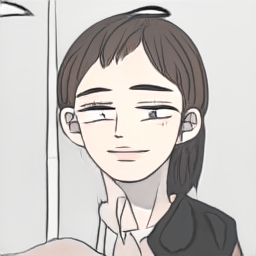

In [ ]:
#@title 3. Generate a single image

#----------------------------------------------
#@markdown **1) Pretrained Model**
#@markdown 
#@markdown Choose a Fine-Tuning model !😊  I trained the model 30k~100k with [Naver Webtoon](https://www.webtoons.com/en/) and [Simpson](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset) Images

network = '\uBC14\uB978\uC5F0\uC560\uAE38\uC7A1\uC774' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'metfaces', 'another pretrained model']
network_pkl = '/content/network/' + meta_data[network][0] + '.pkl'

print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


#----------------------------------------------
#@markdown **2) Seed**
#@markdown
#@markdown Use -1 for random seed or type a specific seed (from 0 up to 2^32-1):

seeds =  -1#@param {type: "number"}

if seeds == -1:
    seeds = np.random.randint(2**32 - 1, size=1)
else:
    seeds = [seeds]

print('Seed : ', seeds)

#----------------------------------------------
#@markdown **3) Truncation**

truncation_psi = 0.95 #@param {type:"slider", min:0, max:1, step:0.05}

#----------------------------------------------
#@markdown **4) noise**

noise_mode = 'random' #@param ['const', 'random', 'none']

#----------------------------------------------
# Labels

label = torch.zeros([1, G.c_dim], device=device)
if G.c_dim != 0:
    label[:, class_idx] = 1




#----------------------------------------------
#@markdown ---
#@markdown **Generate images**
#----------------------------------------------

def generate_images(seeds_ = seeds,
                    latent_vector = None,
                    truncation_psi_ = truncation_psi,
                    noise_mode_ = noise_mode,
                    class_idx = label,
                    network = network_pkl):
  
  imgs=[]

  with dnnlib.util.open_url(network) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

  if latent_vector == None : 
    for seed_idx, seed in enumerate(seeds_):

        # print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
        img = G(z, class_idx, truncation_psi=truncation_psi_, noise_mode=noise_mode_)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        
        imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))
  else:
    for i in range(len(latent_vector)):
      
        img = G(latent_vector[i], class_idx, truncation_psi=truncation_psi_, noise_mode=noise_mode_)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        
        imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))

  return imgs

image = generate_images()
image[0].save('/content/results/generate_image.png')
display(Image(filename='/content/results/generate_image.png'))


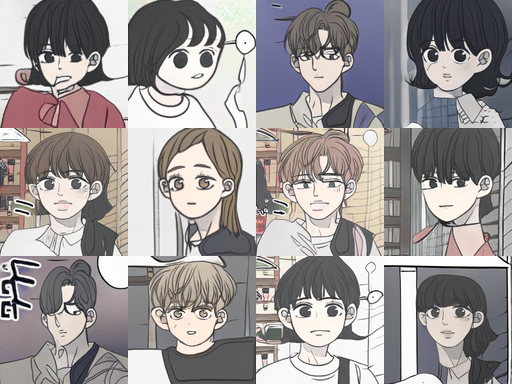

In [ ]:
#@title 4. Generate multiple images

#----------------------------------------------
#@markdown `createImageGide` : A function that draws images into a grid
#----------------------------------------------

def createImageGrid(images, scale=0.25, rows=1, colums=1):

   (w, h) = images[0].size
   w = int(w*scale)
   h = int(h*scale)

   height = rows*h
   width = colums*w

   canvas = PIL.Image.new('RGBA', (width,height), 'white')

   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % colums), h*(i // colums))) 
   return canvas

#----------------------------------------------
#@markdown ---
#@markdown Generate different Images
#----------------------------------------------

rows = 3 #@param {type: "number"}
columns = 4 #@param {type: "number"}

seeds = np.random.randint((2**32 - 1), size=rows*columns)

image_size = 0.5 #@param {type: "number"}

# Loading network...
fine_tuning_model = '\uBC14\uB978\uC5F0\uC560\uAE38\uC7A1\uC774' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'another pretrained model']
network_pkl = '/content/network/' + meta_data[fine_tuning_model][0] + '.pkl'

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


createImageGrid(generate_images(seeds_=seeds, network = network_pkl ), image_size , rows, columns).save('/content/results/generate_multiple_image.png')
display(Image(filename='/content/results/generate_multiple_image.png'))


In [ ]:
#@title 5. Generate interpolation video

#--------------------------
# Loading network
#--------------------------

fine_tuning_model = '\uD504\uB9AC\uB4DC\uB85C\uC6B0' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'another pretrained model']
network_pkl = '/content/network/' + meta_data[fine_tuning_model][0] + '.pkl'

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


#--------------------------
# latent vector
#--------------------------

latent_num = 10 #@param {type: "number"}
seeds = list(np.random.randint((2**32) - 1, size=latent_num))
seeds = seeds + [seeds[0]]


latent_vector = []
for seed in enumerate(seeds):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    latent_vector.append(z)


#--------------------------
# Interpolation latent vector
#--------------------------

number_of_steps = 30 #@param {type: "number"}

z_interpolation = []
for i in range(len(latent_vector)-1):
    for k in range(number_of_steps):
        fraction = k/float(number_of_steps) 
        z_interpolation.append(latent_vector[i+1]*fraction + latent_vector[i]*(1-fraction))

#--------------------------
# Generate Images
#--------------------------

images = generate_images(network = network_pkl, latent_vector=z_interpolation)

In [ ]:
#@title Make & Show Interpolation Video

#--------------------------
# Make a Interpolation Video
#--------------------------

import cv2 

frameSize = (256, 256)
FPS = 30
fourcc = cv2.VideoWriter_fourcc(*'XVID')

video = cv2.VideoWriter('/content/results/interpolation_video.mp4', fourcc, float(FPS), frameSize)

for img in images:
  np_img = np.asarray(img)
  frame = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
  video.write(frame)

video.release()

#--------------------------
# Show a Interpolation Video in Colab
#--------------------------

from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/results/interpolation_video.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

---



Seed :  [4146661189]


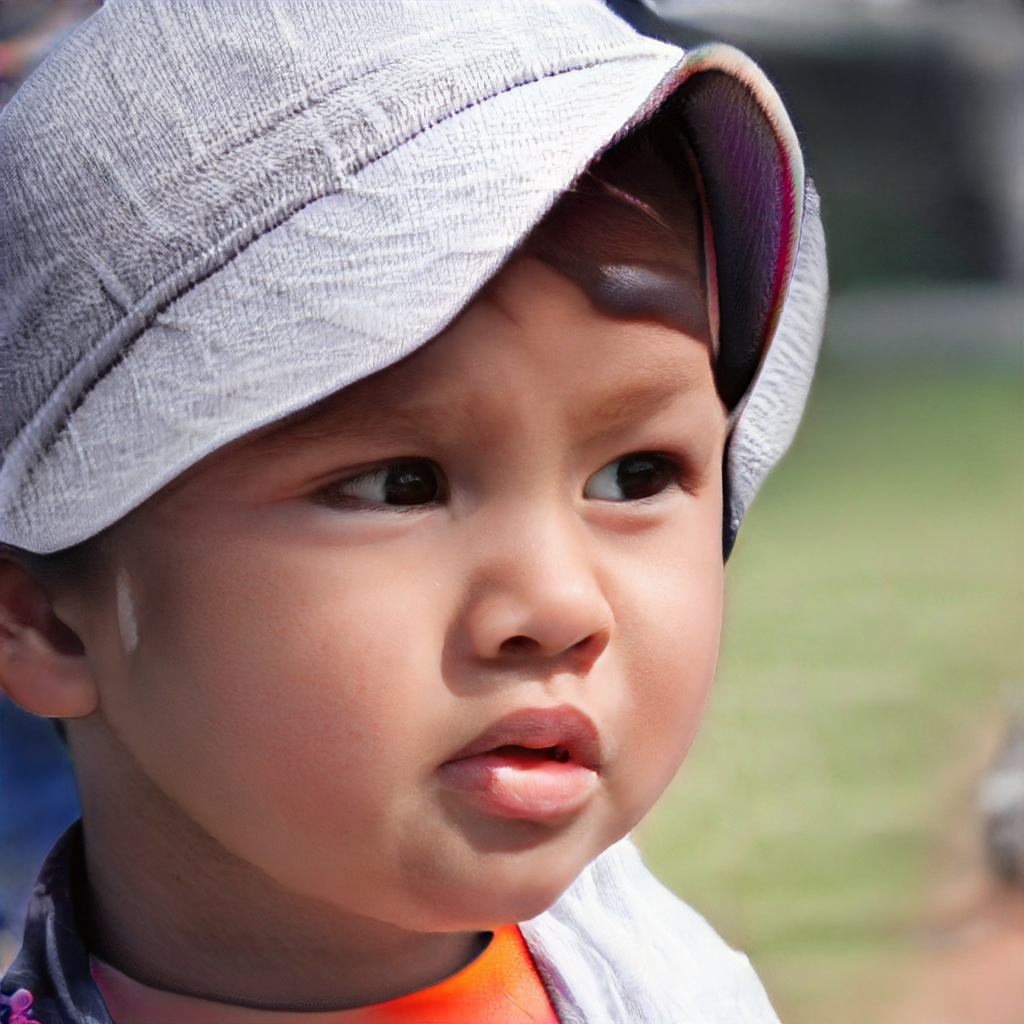

In [ ]:
#@title Ex) Generate Image of FFHQ Dataset 

#----------------------------------------------
#@markdown **1) Seed**
#@markdown
#@markdown Use -1 for random seed or type a specific seed (from 0 up to 2^32-1):

seeds =  -1#@param {type: "number"}

if seeds == -1:
    seeds = np.random.randint(2**32 - 1, size=1)
else:
    seeds = [seeds]

print('Seed : ', seeds)

#----------------------------------------------
#@markdown **2) Truncation**

truncation_psi = 0.95 #@param {type:"slider", min:0, max:1, step:0.05}

#----------------------------------------------
#@markdown **3) noise**

noise_mode = 'random' #@param ['const', 'random', 'none']

#----------------------------------------------
# Labels

label = torch.zeros([1, G.c_dim], device=device)
if G.c_dim != 0:
    label[:, class_idx] = 1


image = generate_images(seeds_=seeds, truncation_psi_=truncation_psi, noise_mode_=noise_mode,
                        network='/content/network/ffhq1024.pkl')

image[0].save('/content/results/generate_image_ffhq.png')
display(Image(filename='/content/results/generate_image_ffhq.png', width=256, height=256))


In [ ]:
#@title [Transfer Learning] Generate interpolation video

#--------------------------
# Loading network
#--------------------------

fine_tuning_model = '\uBC14\uB978\uC5F0\uC560\uAE38\uC7A1\uC774' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'metfaces', 'another pretrained model']
network_pkl = '/content/network/' + meta_data[fine_tuning_model][0] + '.pkl'

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


#--------------------------
# latent vector
#--------------------------

latent_num =  5 #@param {type: "number"}
seeds = list(np.random.randint((2**32) - 1, size=latent_num))
seeds = seeds + [seeds[0]]

latent_vector = []
for seed in enumerate(seeds):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    latent_vector.append(z)


#--------------------------
# Linear Interpolation latent vector
#--------------------------

number_of_steps =  20 #@param {type: "number"}

z_interpolation = []
for i in range(len(latent_vector)-1):
    for k in range(number_of_steps):
        fraction = k/float(number_of_steps) 
        z_interpolation.append(latent_vector[i+1]*fraction + latent_vector[i]*(1-fraction))

#--------------------------
# Generate Images
#--------------------------

# FFHQ Image
images_ffhq =  generate_images(latent_vector=z_interpolation, network='/content/network/ffhq1024.pkl')
# Fine-Tuned Image 
images_transf = generate_images(latent_vector=z_interpolation, network=network_pkl)
images = []



In [ ]:
#@title [Transfer Learning] Generate interpolation video

#--------------------------
# Loading network
#--------------------------

fine_tuning_model = 'simpson' #@param ['simpson', '바른연애길잡이', '연애혁명', '여신강림', '소녀의세계', '기안84', '프리드로우', '신의탑', 'metfaces', 'another pretrained model']
network_pkl = '/content/network/' + meta_data[fine_tuning_model][0] + '.pkl'

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


#--------------------------
# latent vector
#--------------------------

latent_num =  5 #@param {type: "number"}
seeds = list(np.random.randint((2**32) - 1, size=latent_num))
seeds = seeds + [seeds[0]]

latent_vector = []
for seed in enumerate(seeds):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    latent_vector.append(z)


#--------------------------
# Linear Interpolation latent vector
#--------------------------

number_of_steps =  20 #@param {type: "number"}

z_interpolation = []
for i in range(len(latent_vector)-1):
    for k in range(number_of_steps):
        fraction = k/float(number_of_steps) 
        z_interpolation.append(latent_vector[i+1]*fraction + latent_vector[i]*(1-fraction))

#--------------------------
# Generate Images
#--------------------------

# FFHQ Image
images_ffhq =  generate_images(latent_vector=z_interpolation, network='/content/network/ffhq1024.pkl')
# Fine-Tuned Image 
images_transf = generate_images(latent_vector=z_interpolation, network=network_pkl)
images = []

for i in range(len(z_interpolation)):
  canvas = PIL.Image.new('RGBA', (512,256), 'white')

  img = images_ffhq[i].resize((256,256), PIL.Image.ANTIALIAS)
  canvas.paste(img, (0, 0)) 
  img = images_transf[i].resize((256,256), PIL.Image.ANTIALIAS)
  canvas.paste(img, (256, 0))

  images.append(canvas)

#@title Make & Show Interpolation Video

#--------------------------
# Make a Interpolation Video
#--------------------------

import cv2 

frameSize = (512, 256)
FPS = 11
fourcc = cv2.VideoWriter_fourcc(*'XVID')

video = cv2.VideoWriter('/content/results/interpolation_ffhq_transfer.mp4', fourcc, float(FPS), frameSize)

for img in images:
  np_img = np.asarray(img)
  frame = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
  video.write(frame)

video.release()

#--------------------------
# Show a Interpolation Video in Colab
#--------------------------

from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/results/interpolation_ffhq_transfer.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
